In [167]:
import sympy as sp
from sympy import Heaviside
sp.init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mayavi import mlab
from scipy.integrate import cumtrapz

## Material parameters

In [72]:
E_T = sp.Symbol('E_T', real=True, nonnegative=True)
E_N = sp.Symbol('E_N', real=True, nonnegative=True)
gamma = sp.Symbol('gamma', real=True)
K = sp.Symbol('K', real=True)
S = sp.Symbol('S', real=True)
r = sp.Symbol('r', real=True)
c = sp.Symbol('c', real=True)
tau_bar = sp.Symbol(r'\bar{\tau}', real=True, nonnegative=True)
m = sp.Symbol('m', real=True)
q = sp.Symbol('q', real = True, nonpositive = True)

In [73]:
sigma_N = sp.Symbol(r'\sigma_N', real=True)
sigma_N

## State variables

Put the state variables into a matrix. Define the type and properties of the state variables.

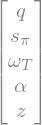

In [74]:
s = sp.Symbol('s', real=True)
omega_T = sp.Symbol(r'omega_T', real=True, nonnegative=True)
s_pi = sp.Symbol(r's_pi', real=True)
alpha = sp.Symbol('alpha', real=True)
z = sp.Symbol('z', real=True)
SV = sp.Matrix([q, s_pi, omega_T, alpha, z])
SV

In [75]:
dot_lambda = sp.Symbol(r'\dot{\lambda}', real=True, nonnegative=True)
dot_lambda

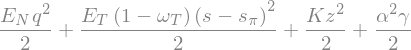

In [77]:
rho_phi = sp.Rational(1,2)* (
    (1-omega_T)*E_T*(s-s_pi)**2 + gamma * alpha**2 + K * z**2 + E_N * q **2)
rho_phi

## Thermodynamic forces

In [78]:
tau = sp.Symbol('tau', real=True)
tau_pi = sp.Symbol(r'tau_pi', real=True)
X = sp.Symbol('X', real=True)
Z = sp.Symbol('Z', real=True, nonnegative=True)
Y_T = sp.Symbol(r'Y_T', real=True)
TF = [sigma_N, tau_pi, Y_T, X, Z] 
TF

## Threshold

In [79]:
tau_eff = sp.Function(r'\tau^{\mathrm{eff}}')(tau_pi, omega_T)
Q = sp.Function('Q')(tau_eff,X)
Q

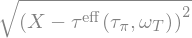

In [80]:
norm_Q = sp.sqrt(Q*Q)
sp.simplify(norm_Q.subs(Q,tau_eff-X))

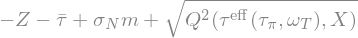

In [81]:
f = norm_Q - Z - tau_bar + m * sigma_N
f

In [82]:
subs_Q = {Q: tau_eff - X}
subs_Q

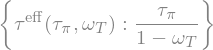

In [83]:
subs_tau_eff = {tau_eff: tau_pi / (1-omega_T)}
subs_tau_eff

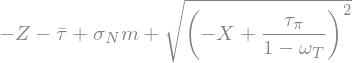

In [84]:
f_TF = f.subs(subs_Q).subs(subs_tau_eff)
f_TF

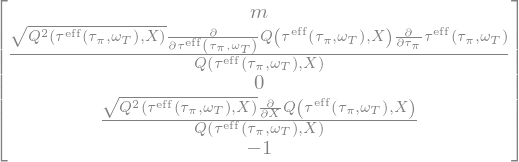

In [85]:
grad_f = sp.Matrix([ f.diff(tf) for tf in  TF ])
grad_f

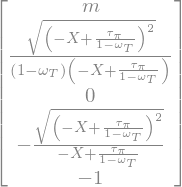

In [87]:
grad_f_TF = grad_f.subs(subs_Q).subs(subs_tau_eff).doit()
grad_f_TF

In [96]:
get_grad_f_TF = sp.lambdify(TF, grad_f_TF,'numpy')

In [97]:
def anim_levelset(get_f,
                  xrange=(-30,30), yrange=(-30, 30), zrange=(-30,30), trange=(0,1),
                  labels=['x','y','z']):
    xmin, xmax = xrange
    ymin, ymax = yrange
    zmin, zmax = zrange
    tmin, tmax = trange
    grid_args = np.mgrid[xmin:xmax:80j, ymin:ymax:80j, zmin:zmax:80j]
    f_args = tuple(grid_args)+(0.00001,)
    #print(f_args)
    f_val = get_f(*f_args)
    contour = mlab.contour3d(
        *tuple(grid_args) + (f_val,),
        contours=[0.0], color=(1, 0, 0)
    )
    xl, yl, zl = labels
    mlab.axes(xlabel=xl, ylabel=yl, zlabel=zl)
    @mlab.animate
    def anim():
        for omega_val in np.linspace(tmin,tmax,100):
            contour.mlab_source.scalars = get_f(*tuple(grid_args)+(omega_val,))
            yield

    anim()
    mlab.show()

In [98]:
if False:
    subs_f_TF_data = ({m:0.1, tau_bar:10})
    get_f = sp.lambdify(
        (sigma_N, tau_pi, omega_T, X, Z), 
        f_TF.subs(subs_f_TF_data), 'numpy')
    anim_levelset(get_f)

## Flow potential

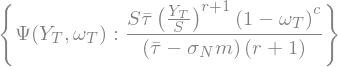

In [99]:
Psi = sp.Function('\Psi')(Y_T,omega_T)
subs_Psi = {Psi: S* (1-omega_T)**c / (r+1) * (Y_T/S)**(r+1)*(tau_bar / (tau_bar-m* sigma_N))}
subs_Psi

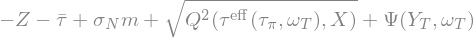

In [100]:
psi = f + Psi
psi

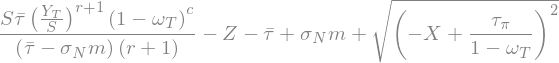

In [101]:
psi_TF = psi.subs(subs_Q).subs(subs_tau_eff).subs(subs_Psi)
psi_TF

In [103]:
if False:
    subs_psi_data = {tau_bar:10, m:0.1, S:5, r:1, c:1, Z:0}
    get_psi = sp.lambdify(
        [tau_pi, X, Y_T, omega_T],
        psi_TF.subs(subs_psi_data), 'numpy')
    anim_levelset(get_psi, zrange=(-10,10))

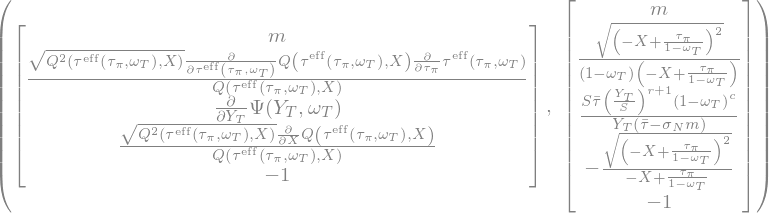

In [104]:
signs = sp.diag(1,1,1,1,1)
grad_psi = signs * sp.Matrix([psi.diff(tf) for tf in TF])
grad_psi_TF = grad_psi.subs(subs_Q).subs(subs_tau_eff).subs(subs_Psi).doit()
grad_psi, grad_psi_TF

In [106]:
subs_d_psi_TF = {var: val for var, val in zip(TF, grad_psi_TF)}

In [107]:
def anim_quiver3d(get_f, get_grad_f,
                  xrange=(-30,30), yrange=(-30, 30), zrange=(-30,30), trange=(0,1),
                  labels=['x','y','z'] ):
    xmin, xmax = xrange
    ymin, ymax = yrange
    zmin, zmax = zrange
    tmin, tmax = trange
    grid_args = np.mgrid[xmin:xmax:20j, ymin:ymax:20j, zmin:zmax:20j]
    f_args = tuple(grid_args)+(tmin,)
    f_val = get_f(*f_args)
    f_contour = mlab.contour3d(
        *tuple(grid_args) + (f_val,),
        contours=[0.0], color=(0, 1, 0)
    )
    x, y, z = grid_args
    psi_val = get_grad_f(*f_args)
    u, v, w = psi_val[(0,1,3),0]
    quiver = mlab.quiver3d(x,y,z,u,v,w)

    xl, yl, zl = labels 
    mlab.axes(xlabel=xl, ylabel=yl, zlabel=zl)
    @mlab.animate
    def anim():
        for omega_val in np.linspace(tmin,tmax,100):
            f_args = tuple(grid_args)+(omega_val,)
            f_contour.mlab_source.scalars = get_f(*f_args)
            psi_val = get_grad_f(*f_args)
            u, v, w = psi_val[(0,1,3),0]
            quiver.mlab_source.u = u
            quiver.mlab_source.v = v
            quiver.mlab_source.w = w
            yield

    anim()
    mlab.show()

In [108]:
if False:
    subs_psi_data = {tau_bar:10, m:0, S:5, r:1, c:1, Z:0}
    get_psi = sp.lambdify(
        (sigma_N, tau_pi,omega_T,X), 
        psi_TF.subs(subs_psi_data), 'numpy')
    get_grad_psi = sp.lambdify(
        [sigma_N, tau_pi,omega_T,X], 
        grad_psi_TF.subs(subs_psi_data), 'numpy')
    anim_quiver3d(get_psi, get_grad_psi, 
                  xrange=(-30,30), yrange=(-30,30), zrange=(-5,5), trange=(0.001, 0.1))

## Thermodynamic forces

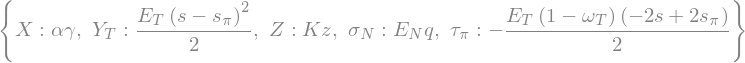

In [114]:
rho_phi
signs = sp.diag(1, -1, -1, 1, 1)
grad_rho_phi =  sp.Matrix([rho_phi.diff(sv) for sv in SV])
subs_TF = {
    var: val for var,val in zip(TF,signs*grad_rho_phi)
}
subs_TF

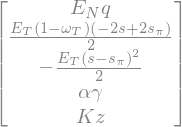

In [115]:
TF_SV = grad_rho_phi
TF_SV

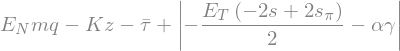

In [116]:
f_SV = f_TF.subs(subs_TF)
f_SV

## Evolution equations

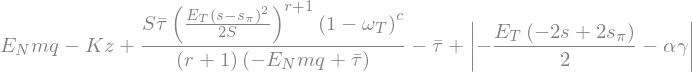

In [117]:
psi_SV = psi_TF.subs(subs_Psi).subs(subs_TF)
psi_SV

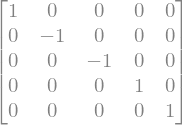

In [118]:
signs

In [121]:
if False:
    subs_psi_SV_data = {K:0.0001, S:0.0001, r:0.1, c:3, m:0.1, E_T:1, s:0, gamma:1, tau_bar:1}
    get_psi_SV = sp.lambdify(
        (q, s_pi,omega_T, alpha, z), 
        psi_SV.subs(subs_psi_SV_data), 'numpy')
    grad_psi_SV = signs * grad_psi_TF.subs(subs_TF)
    get_grad_psi_SV = sp.lambdify(
        (q, s_pi,omega_T, alpha, z), 
        grad_psi_SV.subs(subs_psi_SV_data), 'numpy')
    anim_quiver3d(get_psi_SV, get_grad_psi_SV, 
                  xrange=(-3,3), yrange=(-3,3), zrange=(-3,3),
                  trange=(0,0.1))

**Rates of state variables:**

In [122]:
dot_s, t = sp.symbols(r'\dot{s}, t')

In [123]:
s_t = sp.Function(r's')(t)
s_pi_t = sp.Function(r's_pi')(t)
alpha_t = sp.Function(r'alpha')(t)
z_t = sp.Function(r'z')(t)
q_t = sp.Function(r'q')(t)
omega_t = sp.Function(r'omega_T')(t)
s_t, s_pi_t, alpha_t, z_t, omega_t, q_t 

In [124]:
def var_timify( var ):
    return sp.Function(var.name+'_t')(t)
def var_dotify( var ):
    return sp.Symbol(r'\dot{%s}' % var)
subs_SV_t = {
    var_timify(var) : var for var in SV
}
subs_SV_t

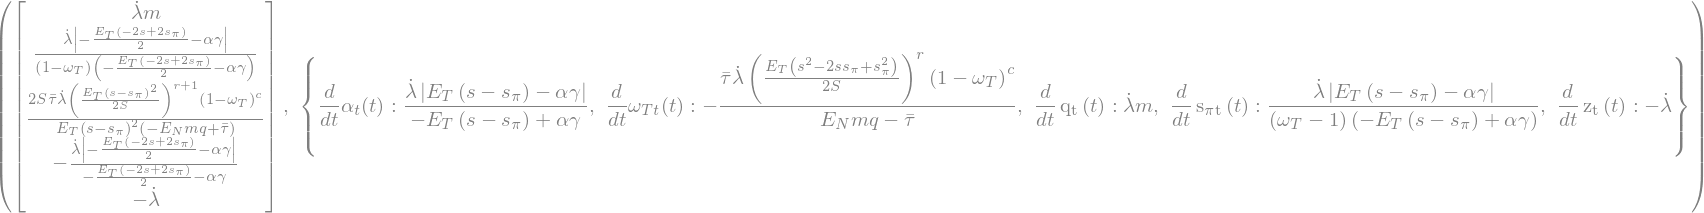

In [125]:
dot_SV_t = dot_lambda * grad_psi_TF.subs(subs_TF)
subs_dot_SV_t = {
    var_timify(var).diff(t): sp.simplify(val) 
    for var, val in zip(SV, dot_SV_t) 
}
dot_SV_t, subs_dot_SV_t

## Rates of thermodynamic forces

In [126]:
subs_timify = {var: var_timify(var)
              for var in list(SV) + [s]}
subs_untimify = {var_timify(var): var
              for var in list(SV)}
subs_timify, subs_untimify

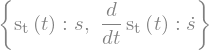

In [127]:
dot_s = sp.Symbol(r'\dot{s}')
subs_s_untimify = {var_timify(s):s, var_timify(s).diff(t): dot_s} 
subs_s_untimify

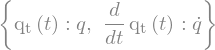

In [128]:
dot_q = sp.Symbol(r'\dot{q}')
subs_q_untimify = {var_timify(q):q, var_timify(q).diff(t): dot_q} 
subs_q_untimify

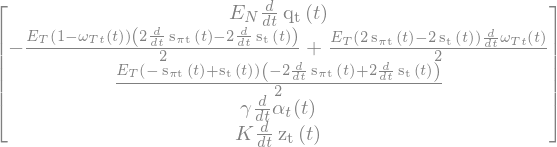

In [129]:
dot_TF = sp.Matrix([
    subs_TF[tf].subs(subs_timify).diff(t)
    for tf in TF ])
dot_TF

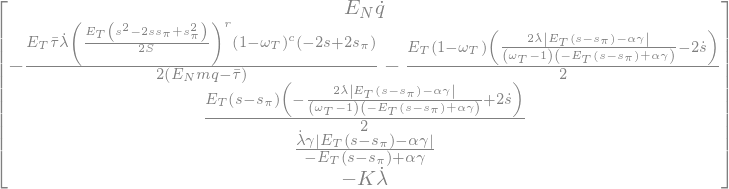

In [130]:
dot_TF_SV = sp.Matrix([
    subs_TF[tf].subs(subs_timify).diff(t).subs(subs_q_untimify).subs(
        subs_dot_SV_t).subs(subs_untimify).subs(subs_s_untimify)
    for tf in TF ])
dot_TF_SV

## Consistency condition

In [131]:
dot_f = sp.simplify((grad_f_TF.subs(subs_TF).T * dot_TF_SV)[0,0])
dot_f;

## Return mapping expression

In [132]:
dot_lambda_solved = sp.solve(dot_f, dot_lambda)[0]
dot_lambda_simplified = sp.simplify(dot_lambda_solved);

In [133]:
data_dict = {E_T:1, E_N:1, m: 0.1, K:0, gamma:0} #              gamma:1, K:1, S:1, r:1, c:1, m:1, tau_bar:1, sigma_N : 0}
dot_lambda_solved.subs(data_dict);

In [134]:
sp.simplify(dot_TF_SV.subs(dot_lambda, dot_lambda_solved).subs(data_dict));

In [135]:
sp.simplify(dot_f.subs(dot_lambda, dot_lambda_solved))

## Test of Consistency Recovery

In [136]:
data_dict = {E_N:1, E_T:1, gamma:1, K:1, S:1, r:1, c:1, m:1, tau_bar:1, sigma_N : 0}

In [137]:
state_dict = {s:5, alpha:0, z:0, s_pi:1, omega_T:sp.Rational(1,2), q : 0 }

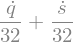

In [138]:
dot_lambda_test = dot_lambda_solved.subs(data_dict).subs(state_dict)
dot_lambda_test

In [139]:
sp.simplify(dot_f.subs(data_dict).subs(state_dict).subs(dot_lambda, dot_lambda_test))

## Time Integration Scheme

In [140]:
#q = Heaviside(q)
material_params = {
    E_N: 1,
    E_T:1, 
#   gamma:0, K:0, 
    gamma:0.2, K:0.1, 
#     S:0, r:0.001, c:1, 
    S:0.006, r:0.001, c:1, 
    tau_bar:1, 
    m:0.4
}

## Discrete evolution equations

In [141]:
q_n, s_pi_n, z_n, alpha_n = sp.symbols(
    r'q_n, s_pi_n, z_n, alpha_n', real=True)
omega_T_n, omega_T_k = sp.symbols(
    r'omega_T_n, omega_T_k', real=True, nonnegative=True)
q_k, s_pi_k, z_k, alpha_k = sp.symbols(
    r'q_k, s_pi_k, z_k, alpha_k', real=True)
dlambda_ = sp.Symbol('lambda_Delta', nonnegative=True)
subs_state_n = {q: q_n, s_pi: s_pi_n, omega_T: omega_T_n, alpha: alpha_n, z: z_n }
subs_state_k = {q: q_k, s_pi: s_pi_k, omega_T: omega_T_k, alpha: alpha_k, z: z_k }
subs_state_n, subs_state_k

**Discrete evolution equatins**

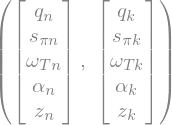

In [143]:
SV_n = sp.Matrix([sv.subs(subs_state_n) for sv in SV])
SV_k = sp.Matrix([sv.subs(subs_state_k) for sv in SV])
SV_n, SV_k

In [70]:
SV_k_expr =  SV_n + dlambda_ * signs * grad_psi_TF.subs(subs_TF).subs(subs_state_k)

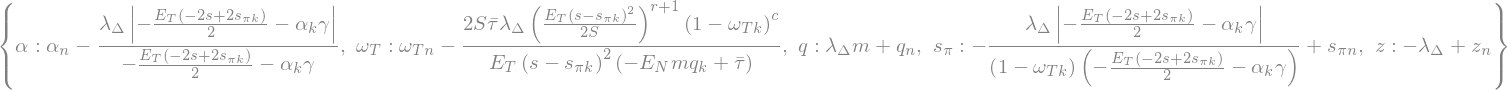

In [67]:
subs_SV_k_expr = {
    sv: expr for sv, expr in zip(SV, list(SV_k_expr))
}
subs_SV_k_expr

In [68]:
get_SV_k = sp.lambdify(
    (q, s, dlambda_, SV_n, SV_k), SV_k_expr.subs(material_params), 'numpy'
)

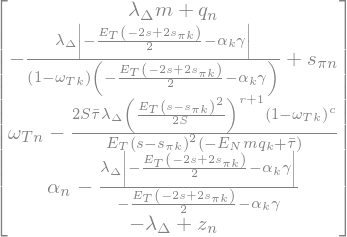

In [53]:
SV_k_expr

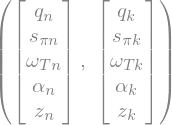

In [54]:
SV_n, SV_k

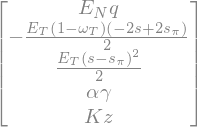

In [55]:
S_TF_SV = signs * TF_SV
get_TF_k = sp.lambdify(
    (q,s,SV), S_TF_SV.subs(material_params), 'numpy'
)
S_TF_SV

In [56]:
f_SV_k = f_SV.subs(subs_SV_k_expr)
get_f_SV_k = sp.lambdify(
    (q, s, dlambda_, SV_n, SV_k), f_SV_k.subs(material_params), 'numpy'
)
f_SV_k;

In [57]:
d_f_SV_k = f_SV_k.diff(dlambda_)
get_d_f_SV_k = sp.lambdify(
    (q, s, dlambda_, SV_n, SV_k), d_f_SV_k.subs(material_params), 'numpy'
)
d_f_SV_k;

In [150]:
def get_response(q_max = 1,s_max=12.6,n_steps=50):
    sv_n = np.zeros((len(SV),), dtype=np.float_)
    sv_k = np.zeros((len(SV),), dtype=np.float_)
    sv_record, tf_record, k_record = [], [], [],
    k, k_max = 0, 2000
    s_t = np.linspace(1e-9,s_max,n_steps+1)
    q_t = np.linspace(1e-9, q_max, n_steps+1)
    for q_n, s_n in zip(q_t, s_t): 
        dlambda0 = 0
        f0 = get_f_SV_k(q_n,s_n,dlambda0,sv_n,sv_k)
        norm_f0 = f0
        k = 0
        while k < k_max:
            if norm_f0 < 1e-10:
                sv_n = np.copy(sv_k)
                tf_n = get_TF_k(q_n,s_n,sv_n).flatten()
                sv_record.append(sv_n)
                tf_record.append(tf_n)
                k_record.append(k)
                break
            df0 = get_d_f_SV_k(q_n,s_n,dlambda0,sv_n,sv_k)
            dlambda0 -= f0/df0
            sv_k = get_SV_k(q_n,s_n,dlambda0,sv_n,sv_k).flatten()
            f0 = get_f_SV_k(q_n,s_n,dlambda0,sv_n,sv_k)
            norm_f0 = np.fabs(f0)
            #print('sv_k', sv_k)
            #print('q_n',q_n)
            k += 1
        else:
            print('no convergence')
    return (
        q_t, s_t, np.array(sv_record,dtype=np.float_),
        np.array(tf_record,dtype=np.float_),
        np.array(k_record,dtype=np.float_)
    )

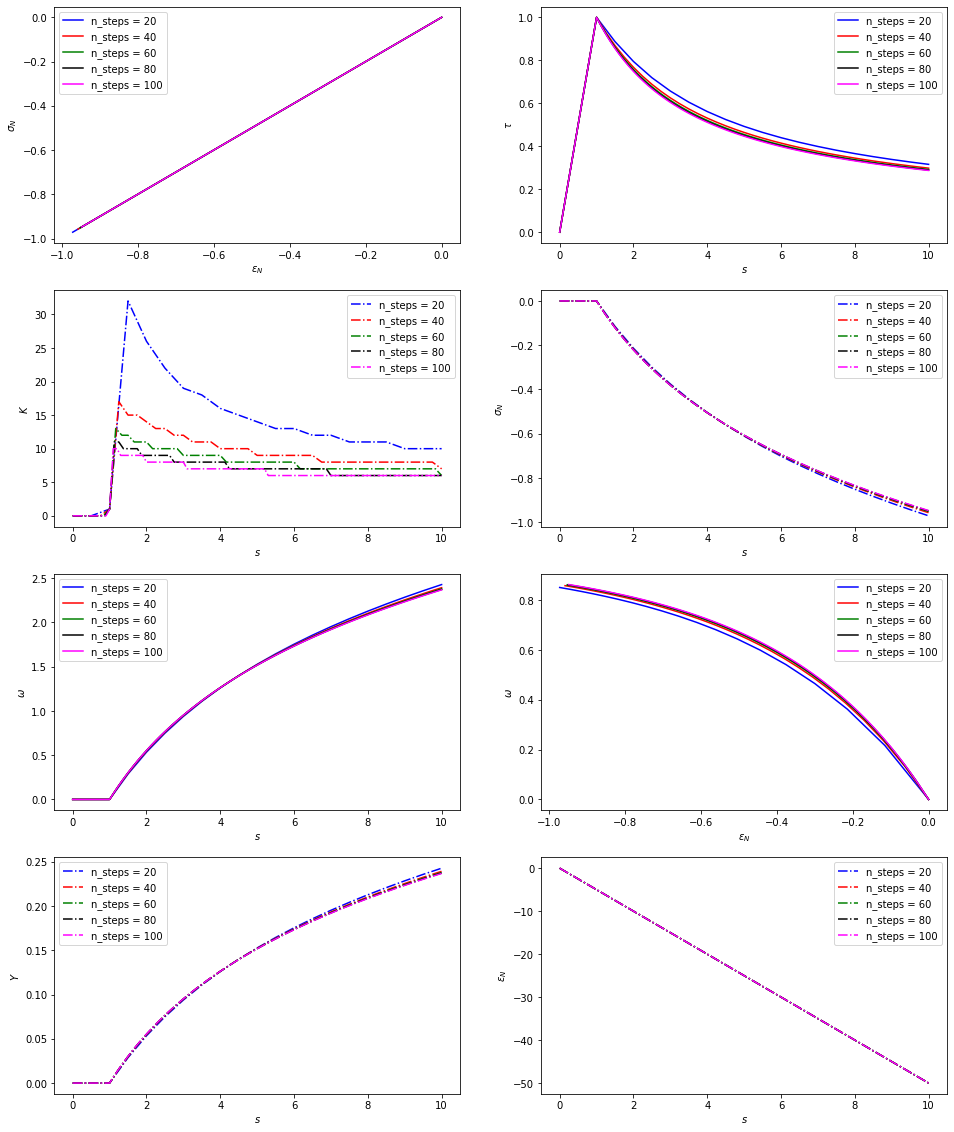

In [151]:
fig, ((ax1,ax2),(ax3,ax4),(ax5, ax6),(ax7, ax8)) = plt.subplots(4,2,figsize=(16,20))
#ax22 = ax2.twinx()
#ax33 = ax3.twinx()
colors = ['blue','red', 'green', 'black', 'magenta' ]
n_step_range = np.arange(1,6)*20
s_max = 10
q_max = -50
for n_step, color in zip(n_step_range, colors):
    q_t, s_t, sv_arr, tf_arr, k_arr = get_response(q_max, s_max,n_step)
    ax1.plot(sv_arr[:,0], tf_arr[:,0], color=color, 
             label='n_steps = %g' % n_step)
    ax1.set_xlabel(r'$\varepsilon_N$'); ax1.set_ylabel(r'$\sigma_N$')
    ax1.legend()
    ax2.plot(s_t, tf_arr[:,1], color = color,
            label='n_steps = %g' % n_step)
    ax2.set_xlabel('$s$'), ax2.set_ylabel(r'$\tau$')
    ax2.legend()
    ax3.plot(s_t, k_arr[:], '-.', color=color, 
             label='n_steps = %g' % n_step)
    ax3.set_xlabel('$s$'); ax3.set_ylabel('$K$')
    ax3.legend()
    ax4.plot(s_t, tf_arr[:,0], '-.', color=color, 
             label='n_steps = %g' % n_step)
    ax4.set_xlabel('$s$'); ax4.set_ylabel(r'$\sigma_N$')
    ax4.legend()
    #ax33.plot(s_t, k_arr[:], '-.', color=color )
    ax5.plot(s_t, sv_arr[:,4], color=color, 
             label='n_steps = %g' % n_step)
    ax5.set_xlabel('$s$'); ax5.set_ylabel(r'$\omega$')
    ax5.legend()
    ax6.plot(sv_arr[:,0], sv_arr[:,2], color=color, 
             label='n_steps = %g' % n_step)
    ax6.set_xlabel(r'$\varepsilon_N$'); ax6.set_ylabel(r'$\omega$')
    ax6.legend()
    ax7.plot(s_t, tf_arr[:,4], '-.', color=color, 
             label='n_steps = %g' % n_step)
    ax7.set_xlabel('$s$'); ax7.set_ylabel('$Y$')
    ax7.legend()
    ax8.plot(s_t, q_t, '-.', color=color, 
             label='n_steps = %g' % n_step)
    ax8.set_xlabel('$s$'); ax8.set_ylabel(r'$\varepsilon_N$')
    ax8.legend()
    #print(q_t)

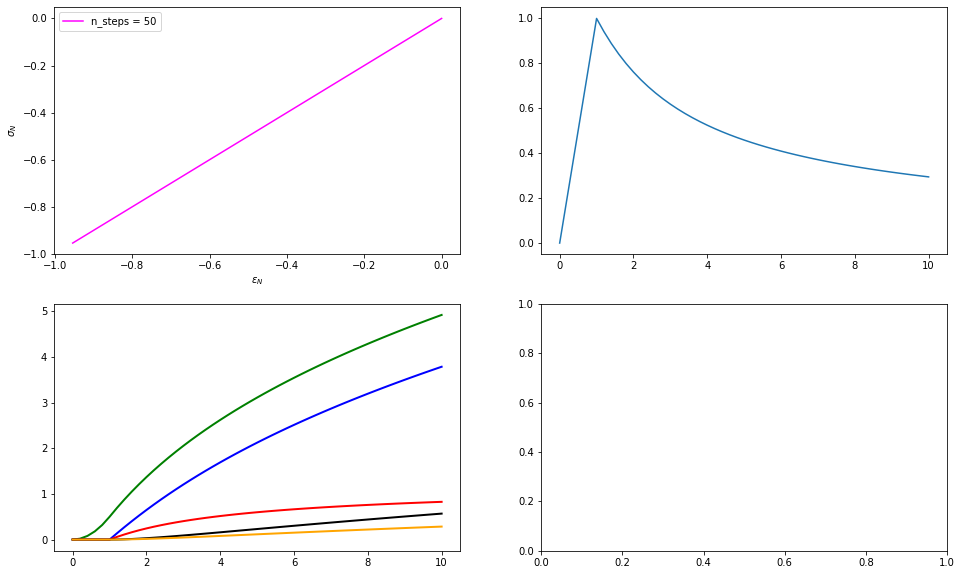

In [188]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,10))
#ax22 = ax2.twinx()
#ax33 = ax3.twinx()
colors = ['blue','red', 'green', 'black', 'magenta' ]
n_step_range = np.arange(1,6)*20
n_step = 50
s_max = 10
q_t, s_t, sv_arr, tf_arr, k_arr = get_response(q_max, s_max, n_step)
ax1.plot(sv_arr[:,0], tf_arr[:,0], color=color, 
         label='n_steps = %g' % n_step)
ax1.set_xlabel(r'$\varepsilon_N$'); ax1.set_ylabel(r'$\sigma_N$')
ax1.legend()
ax2.plot(s_t, tf_arr[:,1])
E_total = cumtrapz(tf_arr[:,1], s_t, initial=0)
E_i = cumtrapz(tf_arr, sv_arr, initial=0, axis=0)
tf_arr.shape, E_i.shape
U = 
ax3.plot(s_t, E_total, color='green', lw=2)
ax3.plot(s_t, E_i[:,1], color='blue', lw=2)
ax3.plot(s_t, E_i[:,2], color='red', lw=2)
ax3.plot(s_t, E_i[:,3], color='black', lw=2)
ax3.plot(s_t, E_i[:,4], color='orange', lw=2 )

## Consistent Tangent Operator

In [ ]:
E_alg = sp.Symbol(r'E^{alg}')
signs = sp.diag(1,1,1,-1,-1)
subs_grad_psi_TF = signs * dot_lambda * grad_psi_TF 
subs_sim_grad_psi_TF = sp.simplify(subs_grad_psi_TF)
E_alg = sp.simplify(((1 - omega_T)*E_T*(dot_s - subs_sim_grad_psi_TF[1])- subs_sim_grad_psi_TF[2] * E_T * (s-s_pi)) / dot_s)
Ealg = E_alg.subs(dot_lambda,dot_lambda_simplified)
Ealgf = sp.simplify(Ealg)
get_alg_stiffness =sp.lambdify(
    (s, SV), Ealgf.subs(subs_TF).subs(material_params), 'numpy')
#Ealgf.subs(subs_TF).subs(material_params)
#get_alg_stiffness
#subs_sim_grad_psi_TF
#E_alg
#Ealg
Ealgf

In [ ]:
E_sec= sp.Symbol('E', real=True)
E_sec = (1-omega_T)*E_T
get_E_sec = sp.lambdify(
    (s, SV),E_sec.subs(material_params), 'numpy'
)

In [ ]:
def get_response(s_max=12.6,n_steps=20):
    sv_n = np.zeros((len(SV),), dtype=np.float_)
    sv_k = np.zeros((len(SV),), dtype=np.float_)
    sv_record, tf_record, k_record, alg_stiff_record, e_stiff_ppr, e_stiff_sec = [], [], [], [], [], []
    k_max = 2000
    s_t = np.linspace(1e-9,s_max,n_steps+1)
    for s_n in s_t: 
        dlambda0 = 0
        f0 = get_f_SV_k(s_n,dlambda0,sv_n,sv_k)
        norm_f0 = f0
        k = 0
        while k < k_max:
            if norm_f0 < 1e-10:
                sv_n = np.copy(sv_k)
                tf_n = get_TF_k(s_n,sv_n).flatten()
                algstiff = get_alg_stiffness(s_n,sv_n).flatten()
                alg_stiff_record.append(algstiff)
                E_stiff = get_E_stiff(s_n,sv_n).flatten()
                e_stiff_ppr.append(E_stiff)
                E_sec = get_E_sec(s_n,sv_n).flatten()
                e_stiff_sec.append(E_sec)
                #print(algstiff)
                sv_record.append(sv_n)
                tf_record.append(tf_n)
                k_record.append(k)
                break
            df0 = get_d_f_SV_k(s_n,dlambda0,sv_n,sv_k)
            dlambda0 -= f0/df0
            sv_k = get_SV_k(s_n,dlambda0,sv_n,sv_k).flatten()
            f0 = get_f_SV_k(s_n,dlambda0,sv_n,sv_k)
            norm_f0 = np.fabs(f0)
            k += 1
        else:
            print('no convergence')
    return (
        s_t, np.array(sv_record,dtype=np.float_),
        np.array(tf_record,dtype=np.float_),
        np.array(k_record,dtype=np.float_),
        np.array(alg_stiff_record,dtype=np.float_),
        np.array(e_stiff_ppr,dtype=np.float_),
        np.array(e_stiff_sec,dtype=np.float_)
    )

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,8))
#ax11 = ax1.twinx()
#ax22 = ax2.twinx()
colors = ['blue','red', 'green', 'black', 'magenta' ]
n_step_range = np.arange(1,2)*100
s_max = 5
for n_step, color in zip(n_step_range, colors):
    s_t, sv_arr, tf_arr, k_arr, alg_arr, e_ppr, e_sec = get_response(s_max,n_step)
#     print(np.shape(alg_arr[:]))
    ax1.plot(s_t, alg_arr[:], color=color, 
              label='n_steps = %g' % n_step)
    ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$E_{alg}$')
    ax1.legend()
    ax2.plot(s_t, tf_arr[:,0], color=color, 
             label='n_steps = %g' % n_step)
    ax2.set_xlabel('$s$'); ax2.set_ylabel(r'$\tau$')
    ax2.legend()
    ax3.plot(s_t, e_ppr[:], color=color, 
             label='n_steps = %g' % n_step)
    ax3.set_xlabel('$s$'); ax3.set_ylabel('$E$')
    ax3.legend()
    ax4.plot(s_t, e_sec[:], color=color, 
             label='n_steps = %g' % n_step)
    ax4.set_xlabel('$s$'); ax4.set_ylabel('$Es$')
    ax4.legend()
#     ax11.plot(s_t, k_arr[:], '-.', color=color )
#     ax2.plot(s_t, sv_arr[:,3], color=color, 
#              label='n_steps = %g' % n_step)
#     ax2.set_xlabel('$s$'); ax2.set_ylabel(r'$\omega$')
#     ax22.plot(s_t, tf_arr[:,3], '-.', color=color, 
#              label='n_steps = %g' % n_step)
#     ax22.set_ylabel('$Y$')
#     ax3.plot(s_t, tf_arr[:,1], color=color, 
#              label='n_steps = %g' % n_step)
#     ax3.set_xlabel('$s$'); ax3.set_ylabel(r'$X$')
#     ax4.plot(s_t, tf_arr[:,2], color=color, 
#              label='n_steps = %g' % n_step)
#     ax4.set_xlabel('$s$'); ax4.set_ylabel(r'$Z$')